# CS410 Text Information Systems 
## Final Project: Text Classification Competition

### Group members: Claire Brekken, YiZi Xiao

# Table of contents
<a id='top'></a>

1. [Problem statement](#problem_statement)
2. [Setup](#setup)
    - [Import packages](#import_packages)
    - [Define directories](#define_dirs)
3. [Run feature engineering](#feat_eng)
4. [Feature analysis](#feat_analysis)
    - [Load data](#load_data)
    - [PCA analysis](#pca)
    - [Feature visualization](#feat_viz)   
        - [Violin plot](#violin)   
        - [ANOVA F score](#anova)   
        - [TSNE](#tsne)   
5. [Conventional supervised learning](#conv_sup_learn)
    - [Spot-check models](#spot_check)
    - [Hyperparameter tuning](#hparam)
    - [Ensemble methods](#ensemble)
        - [XGBOOST](#xgboost)   
        - [Voting classifier](#vote_clf)   
        - [Stacking classifier](#stacking_clf)   
    - [Retrain final models](#retrain)
    - [Prediction on test set](#pred)

# 1. Problem statement

<a id='problem_statement'></a>
[Return to top](#top)

### Text Classification Competition: Twitter Sarcasm Detection 

Dataset format:

Each line contains a JSON object with the following fields : 
- ***response*** :  the Tweet to be classified
- ***context*** : the conversation context of the ***response***
	- Note, the context is an ordered list of dialogue, i.e., if the context contains three elements, `c1`, `c2`, `c3`, in that order, then `c2` is a reply to `c1` and `c3` is a reply to `c2`. Further, the Tweet to be classified is a reply to `c3`.
- ***label*** : `SARCASM` or `NOT_SARCASM` 

- ***id***:  String identifier for sample. This id will be required when making submissions. (ONLY in test data)

For instance, for the following training example : 

`"label": "SARCASM", "response": "@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..", "context": ["A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it .", "@USER If your child isn't named Barron ... #BeBest Melania couldn't care less . Fact . 💯"]`

The response tweet, "@USER @USER @USER I don't get this..." is a reply to its immediate context "@USER If your child isn't..." which is a reply to "A minor child deserves privacy...". Your goal is to predict the label of the "response" while optionally using the context (i.e, the immediate or the full context).

***Dataset size statistics*** :

| Train | Test |
|-------|------|
| 5000  | 1800 |

For Test, we've provided you the ***response*** and the ***context***. We also provide the ***id*** (i.e., identifier) to report the results.

***Submission Instructions*** : Follow the same instructions as for the MPs -- create a private copy of this repo and add a webhook to connect to LiveDataLab.Please add a comma separated file named `answer.txt` containing the predictions on the test dataset. The file should have no headers and have exactly 1800 rows. Each row must have the sample id and the predicted label. For example:

twitter_1,SARCASM  
twitter_2,NOT_SARCASM  
...


# 2. Setup

<a id='setup'></a>
[Return to top](#top)

### Import packages

<a id='import_packages'></a>
[Return to top](#top)

In [27]:
import pandas                        as     pd
import numpy                         as     np
import seaborn                       as     sns
import os 
import matplotlib.pyplot             as     plt
from   utils_text_clf                import utils_text_clf as utils
from   sklearn.feature_selection     import f_classif, \
                                            VarianceThreshold, \
                                            SelectKBest
from   sklearn.model_selection       import StratifiedKFold, \
                                            cross_validate, \
                                            cross_val_predict, \
                                            cross_val_score, \
                                            GridSearchCV, \
                                            train_test_split, \
                                            ShuffleSplit
from   sklearn.pipeline              import Pipeline, \
                                            make_pipeline
from   sklearn.preprocessing         import StandardScaler, \
                                            RobustScaler, \
                                            MinMaxScaler
from   sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from   sklearn.tree                  import DecisionTreeClassifier
from   sklearn.linear_model          import LogisticRegression, \
                                            SGDClassifier
from   sklearn.svm                   import LinearSVC, SVC
from   sklearn.neighbors             import KNeighborsClassifier
from   sklearn.naive_bayes           import GaussianNB
from   sklearn.ensemble              import RandomForestClassifier, \
                                            AdaBoostClassifier, \
                                            GradientBoostingClassifier, \
                                            VotingClassifier
from   mlxtend.classifier            import StackingClassifier
from   mlxtend.feature_selection     import ColumnSelector
from   sklearn.manifold              import TSNE
from   sklearn.decomposition         import PCA
from   xgboost                       import XGBClassifier
import xgboost                       as     xgb
from   sklearn.metrics               import roc_curve, \
                                            f1_score
from   scipy                         import interp
from   pathlib                       import Path
from   pickle                        import dump
import joblib

# Turn interactive plotting off
plt.ion()  
import warnings
warnings.filterwarnings("ignore")

### Define directories

<a id='define_dirs'></a>
[Return to top](#top)

In [3]:
#%% Enter mutable info

data_dir    = os.path.join(os.getcwd(), 'data')
results_dir = os.path.join(os.getcwd(), 'results')

# training data 
#file_train = 'train.jsonl'

# training data
file_train  = 'train_feature_engineering.csv';
file_test   = 'test_feature_engineering.csv'

#file_train = os.path.join(data_dir, file_train) 
file_train  = os.path.join(data_dir, file_train) 
file_test   = os.path.join(data_dir, file_test)

# 3. Run feature engineering

<a id='feat_eng'></a>
[Return to top](#top)

In [2]:
#%% run feature engineering code 
%run feature_engineering.py
print('done!')

# 4. Feature analysis

<a id='feat_analysis'></a>
[Return to top](#top)

### Load data

<a id='load_data'></a>
[Return to top](#top)

In [4]:
#%% load in data 

#df_train = utils.parse_json(file_train)
df_train  = pd.read_csv(file_train)

# feats
x_train  = df_train.iloc[:, 1:]

# labels 
y_train  = df_train.label

# convert labels to binary (1 - sarcasm)
y_train  = [1 if i == 'SARCASM' else 0 for i in y_train]

In [5]:
#%% check label proportions 

# print count
print('The count of sarcastic tweets is:', y_train.count(1))
print('The count of non-sarcastic tweets is:', y_train.count(0))

The count of sarcastic tweets is: 2500
The count of non-sarcastic tweets is: 2500


In [6]:
# check the size of the training data 
x_train.shape

(5000, 29)

In [7]:
x_train.describe()

,users_tagged,num_hashtags,num_capital,tweet_length_words,tweet_length_char,average_token_length,contains_laughter,contains_ellipses,strong_negations,strong_affirmatives,...,context_tweet_length_char,context_average_token_length,context_contains_laughter,context_contains_ellipses,context_strong_negations,context_strong_affirmatives,context_interjections,context_intensifiers,context_punctuation,context_emojis
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.000000,5000.000000
mean,1.947200,0.733800,5.856000,25.357800,100.386400,0.255635,0.032000,0.165800,0.209800,0.178600,...,561.159000,0.782949,0.0,0.0,0.0,0.0,0.0,0.0,1.998800,1.212000
std,0.933266,1.059227,8.217638,13.401869,51.590365,0.042288,0.184886,0.479538,0.491765,0.438566,...,537.603877,0.658256,0.0,0.0,0.0,0.0,0.0,0.0,3.286359,4.211865
min,0.000000,0.000000,0.000000,8.000000,24.000000,0.117117,0.000000,0.000000,0.000000,0.000000,...,86.000000,0.281854,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,1.000000,0.000000,2.000000,16.000000,64.000000,0.227273,0.000000,0.000000,0.000000,0.000000,...,250.000000,0.404089,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
50%,2.000000,0.000000,4.000000,21.000000,86.000000,0.253012,0.000000,0.000000,0.000000,0.000000,...,392.000000,0.547531,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
75%,3.000000,1.000000,7.000000,31.000000,122.250000,0.279570,0.000000,0.000000,0.000000,0.000000,...,630.000000,0.854243,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,1.000000
max,4.000000,3.000000,165.000000,77.000000,238.000000,0.522727,2.000000,5.000000,4.000000,4.000000,...,5788.000000,5.404175,0.0,0.0,0.0,0.0,0.0,0.0,70.000000,80.000000


Remove features with 0 variance 

In [8]:
selector_var = VarianceThreshold()

# select feats with var > 0
selector_var.fit(x_train)

# filter 
x_train = x_train[x_train.columns[selector_var.get_support(indices = True)]]

In [9]:
x_train.head()

,users_tagged,num_hashtags,num_capital,tweet_length_words,tweet_length_char,average_token_length,contains_laughter,contains_ellipses,strong_negations,strong_affirmatives,...,punctuation,emojis,ngram_feature,context_users_tagged,context_num_hashtags,context_tweet_length_words,context_tweet_length_char,context_average_token_length,context_punctuation,context_emojis
0,3,0,1,25,99,0.252525,0,3,0,0,...,3,0,31.0,1,1,55,281,0.390073,0,1
1,2,0,4,21,88,0.238636,0,0,0,0,...,1,0,27.0,4,0,27,126,0.429294,1,0
2,3,1,13,14,73,0.191781,0,0,0,0,...,1,0,14.0,1,0,44,196,0.453922,0,0
3,2,0,6,21,108,0.194444,0,0,0,1,...,0,0,25.0,1,0,56,304,0.361325,0,0
4,2,3,22,30,143,0.209790,0,0,0,0,...,0,0,34.0,1,0,63,316,0.430424,0,0


### PCA analysis

<a id='pca'></a>
[Return to top](#top)

In [10]:
# compute PCAs
x_train_scaled = StandardScaler().fit_transform(x_train)
pca            = PCA().fit(x_train_scaled)
print('pca done!')

pca done!


In [11]:
# variance explained 
var_exp = np.cumsum(pca.explained_variance_ratio_)

# num of components 
n_comp  = range(len(var_exp))

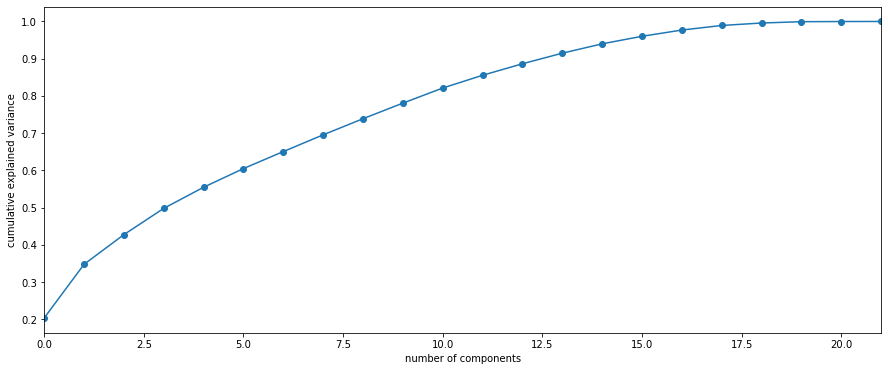

In [12]:
# plot explained variance vs. # of components 
ax = plt.figure(figsize = (15, 6))
plt.plot(n_comp, var_exp, '-o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance') 
plt.autoscale(enable = True, axis = 'x', tight = True)

Find # of PCA components needed to explain 90% of variance in the data 

In [13]:
n_pca = np.where(var_exp >= 0.9)[0][0]
print(n_pca)

13


In [14]:
# save session 
import dill 
dill.dump_session('nb_pca_complete.db')
print('session saved!')

session saved!


In [15]:
# load session 
import dill 
dill.load_session('nb_pca_complete.db')
print('session loaded!')

session loaded!


### Feature visualization

<a id='feat_viz'></a>
[Return to top](#top)        

In [16]:
# represent data using pca feats 
# x_train_pca = PCA(n_components = n_pca).fit_transform(x_train_scaled)

In [17]:
# x_train_pca.shape

### Violin plot

<a id='violin'></a>
[Return to top](#top)

In [18]:
# prepare data 

# scale feats 
x_train_scaled  = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)

# combine x,y
df_train_scaled = pd.concat([df_train.label, x_train_scaled], axis = 1)

# unpivot
data            = pd.melt(df_train_scaled,
                          id_vars    = 'label',
                          var_name   = "features",
                          value_name = 'value')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'users_tagged'),
  Text(1, 0, 'num_hashtags'),
  Text(2, 0, 'num_capital'),
  Text(3, 0, 'tweet_length_words'),
  Text(4, 0, 'tweet_length_char'),
  Text(5, 0, 'average_token_length'),
  Text(6, 0, 'contains_laughter'),
  Text(7, 0, 'contains_ellipses'),
  Text(8, 0, 'strong_negations'),
  Text(9, 0, 'strong_affirmatives'),
  Text(10, 0, 'interjections'),
  Text(11, 0, 'intensifiers'),
  Text(12, 0, 'punctuation'),
  Text(13, 0, 'emojis'),
  Text(14, 0, 'ngram_feature'),
  Text(15, 0, 'context_users_tagged'),
  Text(16, 0, 'context_num_hashtags'),
  Text(17, 0, 'context_tweet_length_words'),
  Text(18, 0, 'context_tweet_length_char'),
  Text(19, 0, 'context_average_token_length'),
  Text(20, 0, 'context_punctuation'),
  Text(21, 0, 'context_emojis')])

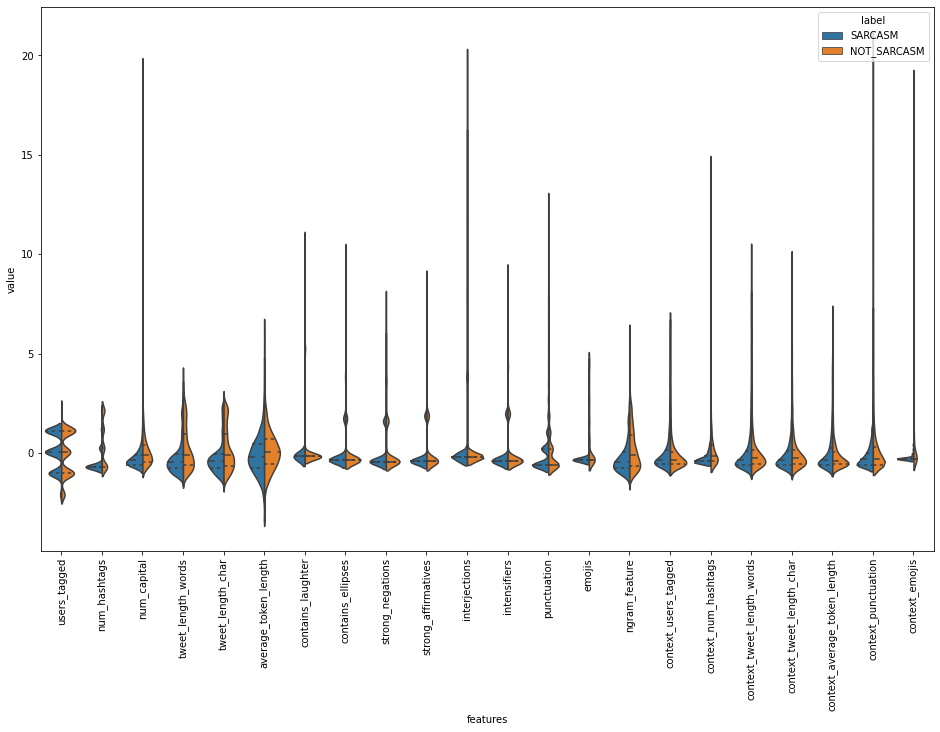

In [19]:
# violin plot 
plt.figure(figsize   = (16,10))
sns.violinplot(x     = "features", 
               y     = "value", 
               hue   = "label", 
               data  = data, 
               split = True, 
               inner = "quart")

plt.xticks(rotation  = 90)

### ANOVA F-Score 

<a id='anova'></a>
[Return to top](#top)

<AxesSubplot:title={'center':'normalized F-score'}>

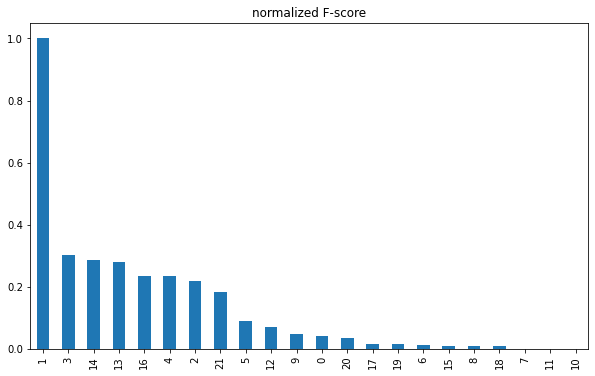

In [20]:
# compute ANOVA F-scores
fvals,_ = f_classif(x_train, y_train)

# normalize by max F score
f_imp   = pd.Series(fvals).div(fvals.max())

# sort in descending order 
f_imp.sort_values()[::-1].plot(kind    = 'bar', 
                               title   = "normalized F-score",
                               figsize = (10,6))

### TSNE

<a id='tsne'></a>
[Return to top](#top)

In [23]:
# scale feats 
x_train_scaled  = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)

In [24]:
# visualize features in low-dimensional space
tsne     = TSNE(n_components = 3, random_state = 42)

# transform on data 
tsne_obj = tsne.fit_transform(x_train_scaled)

# put results into a df
tsne_df  = pd.DataFrame({'x' : tsne_obj[:,0], 
                         'y' : tsne_obj[:,1], 
                         'z' : tsne_obj[:,2], 
                         'label': y_train})

print('done!')

done!


In [25]:
# save session 
import dill 
dill.dump_session('nb_tsne_complete.db')
print('session saved!')

session saved!


In [26]:
# load session 
import dill 
dill.load_session('nb_tsne_complete.db')
print('session loaded!')

session loaded!


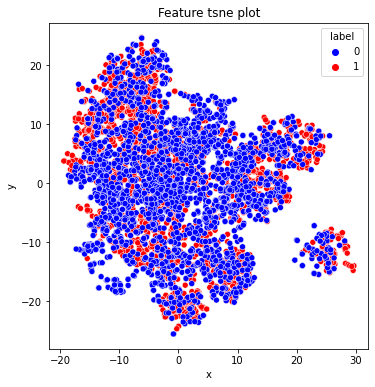

<Figure size 432x288 with 0 Axes>

In [27]:
#%% 2D scattrplot 
ax = plt.figure(figsize = (15, 6))
sns.scatterplot(x = "x", y = "y", hue = "label", palette = ["blue", "red"], 
                legend = 'full', data = tsne_df);
plt.title('Feature tsne plot')
plt.gca().set_aspect('equal', adjustable = 'box')

fig_name  = 'feat_tsne_plot_2d.jpg'
fig_file  = os.path.join(results_dir, fig_name)

# manager   = plt.get_current_fig_manager()
# manager.window.showMaximized()
plt.show()
plt.pause(0.1) # needed for the image to be saved at full size
plt.savefig(fig_file)

In [28]:
#%% 3D scatterplot 
from mpl_toolkits.mplot3d import axes3d    
%matplotlib qt 
ax = plt.figure(figsize=(16,10)).gca(projection = '3d')

ax.scatter3D(xs    = tsne_df.loc[tsne_df['label'] == 0]["x"],
             ys    = tsne_df.loc[tsne_df['label'] == 0]["y"],
             zs    = tsne_df.loc[tsne_df['label'] == 0]["z"],
             c     = 'blue', 
             alpha = 0.5,
             label = '0') 

ax.scatter3D(xs    = tsne_df.loc[tsne_df['label'] == 1]["x"],
             ys    = tsne_df.loc[tsne_df['label'] == 1]["y"],
             zs    = tsne_df.loc[tsne_df['label'] == 1]["z"],
             c     = 'red',
             alpha = 0.5,
             facecolors='none',
             label = '1') 

ax.set_xlabel('tsne_1')
ax.set_ylabel('tsne_2')
ax.set_zlabel('tsne_3')

plt.title('feat tsne scatterplot')
plt.legend()
plt.show()

fig_name  = 'feat_tsne_plot_3d.pickle'
fig_file  = os.path.join(results_dir, fig_name)

# save figure 
output    = open(fig_file, 'wb')
dump(plt.gcf(), output)
output.close()

In [29]:
%matplotlib inline

# 5. Conventional supervised learning 

<a id='conv_sup_learn'></a>
[Return to top](#top)

### Spot-check models

<a id='spot_check'></a>
[Return to top](#top)

In [30]:
# create base models 

# lda 
lda_clf       = LinearDiscriminantAnalysis()
lda           = Pipeline([('scaler',    StandardScaler()), 
                          ('lda_clf',   lda_clf)]) 

# SGD
sgd_clf       = SGDClassifier(max_iter     = 10000,
                              loss         = 'log', 
                              penalty      = 'l1', 
                              tol          = 1e-4, 
                              class_weight = 'balanced')
sgd           = Pipeline([('scaler',    StandardScaler()), 
                          ('sgd_clf',   sgd_clf)]) 

# decision tree
dtree_clf     = DecisionTreeClassifier(class_weight = 'balanced', 
                                       random_state = 42)
dtree         = Pipeline([('scaler',    StandardScaler()), 
                          ('dtree_clf', dtree_clf)]) 

# logistic regression 
logreg_clf    = LogisticRegression(n_jobs       = -1, 
                                   class_weight = 'balanced', 
                                   random_state = 42)
logreg        = Pipeline([('scaler',     StandardScaler()),
                          ('logreg_clf', logreg_clf)]) 

# linear SVM
svc_lin_clf   = LinearSVC(max_iter     = 20000, 
                          class_weight = 'balanced', 
                          random_state = 42)
svc_lin       = Pipeline([('scaler',      StandardScaler()),
                          ('svc_lin_clf', svc_lin_clf)]) 

# rbf kernel SVM
svc_rbf_clf   = SVC(kernel       = 'rbf', 
                    C            = 1, 
                    gamma        = 'auto', 
                    probability  = True, 
                    max_iter     = 20000, 
                    random_state = 42)
svc_rbf       = Pipeline([('scaler',      StandardScaler()),
                          ('svc_rbf_clf', svc_rbf_clf)]) 

# naive Bayes 
NB_clf        = GaussianNB()
NB            = Pipeline([('scaler', StandardScaler()),
                          ('NB_clf', NB_clf)]) 

# KNN
knn_clf       = KNeighborsClassifier(n_jobs       = -1)
knn           = Pipeline([('scaler',  StandardScaler()),
                          ('knn_clf', knn_clf)]) 

# random forest classifier
rndf_clf      = RandomForestClassifier(n_estimators   = 250,  
                                       max_leaf_nodes = 16, 
                                       n_jobs         = -1, 
                                       class_weight   = 'balanced', 
                                       random_state   = 42)
rndf          = Pipeline([('scaler',   StandardScaler()),
                          ('rndf_clf', rndf_clf)]) 

# xgboost
xgboost_clf   = xgb.XGBClassifier(seed = 42)
xgboost       = Pipeline([('scaler',  StandardScaler()),
                          ('xgb_clf', xgboost_clf)]) 

# stochastic gradient boosting
gb_clf        = GradientBoostingClassifier(random_state = 42)
gb            = Pipeline([('scaler',  StandardScaler()),
                          ('gb_clf',  gb_clf)])

# adaboost
adb_clf       = AdaBoostClassifier(random_state = 42)
adb           = Pipeline([('scaler',  StandardScaler()),
                          ('adb_clf', adb_clf)]) 

#%% create model pipeline 

# Append models 
models        = [] 
models.append(['LDA'   , lda])
models.append(['SGD'   , sgd])
models.append(['DTREE' , dtree])
models.append(['LOGREG', logreg])
models.append(['SVCLIN', svc_lin])
models.append(['SVCRBF', svc_rbf])
models.append(['KNN'   , knn])
models.append(['NB'    , NB])
models.append(['RNDF'  , rndf])
models.append(['XGB'   , xgboost])

In [31]:
#%% set cross validation metrics 

n_splits      = 10 # folds 
cv            = StratifiedKFold(n_splits = n_splits, random_state = 42)
scores        = ['accuracy', 'recall', 'precision', 'roc_auc', 'f1']

#%% prepare cross-validation storage

# define the columns of the cross-validation results dataframe 
xval_cols     = ['classifier', 
                 'recall', 
                 'precision',
                 'f1',
                 'accuracy',
                 'roc_auc']

roc_cols      = ['classifier', 'tpr', 'fpr']

# dataframe to store cross-validation results 
df_xval       = pd.DataFrame(index = range(n_splits), columns = xval_cols)
df_xval_all   = pd.DataFrame()
df_xval_roc   = pd.DataFrame()

In [32]:
#%% spot check models on training data 

# loop through the classifiers 

for i, (name, model) in enumerate(models): 

    # cross-validate and compute scores 
    score_results              = cross_validate(model, 
                                                x_train, 
                                                y_train, 
                                                scoring            = scores, 
                                                cv                 = cv, 
                                                return_train_score = False, 
                                                n_jobs             = -1)
    
    print(name + ' cross-validation completed')

    # clean up the df 
    score_results              = pd.DataFrame(score_results).loc[:,['test_accuracy', 'test_f1', 'test_recall', 'test_precision', 'test_roc_auc']]
    score_results.columns      = score_results.columns.str.replace('test_','')
    
    # store the metric results 
    for metric in score_results.columns:
        df_xval.loc[:, metric] = score_results[metric]
        
    # Fill in the 'classifier' column 
    df_xval['classifier']      = np.repeat(name, n_splits, axis = 0)

    # compute class prediction probabilities 
    if hasattr(model, 'predict_proba'):
        y_pred                 = cross_val_predict(model, 
                                                   x_train, 
                                                   y_train, 
                                                   cv     = cv, 
                                                   n_jobs = -1, 
                                                   method = 'predict_proba')
        print(name + ' cross_val_predict completed')
                
    # compute the fpr, tpr
    fpr_reg                    = np.linspace(0, 1, 501) # at regular ticks 
            
    fpr, tpr, _                = roc_curve(y_train, y_pred[:,1], pos_label = 1)
    tpr                        = interp(fpr_reg, fpr, tpr)
        
    # Store fpr, tpr
    run_dict                   = dict.fromkeys(roc_cols) 
    run_dict['fpr']            = list(fpr_reg)
    run_dict['tpr']            = list(tpr)
    run_dict['classifier']     = name

    # append to the roc results dataframe 
    df_xval_roc                = df_xval_roc.append(pd.Series(run_dict).to_frame().T, ignore_index = True) 

    # append to the overall cross-validation results dataframe 
    df_xval_all                = df_xval_all.append(df_xval, ignore_index = True)
    
print('all done!')


LDA cross-validation completed
LDA cross_val_predict completed
SGD cross-validation completed
SGD cross_val_predict completed
DTREE cross-validation completed
DTREE cross_val_predict completed
LOGREG cross-validation completed
LOGREG cross_val_predict completed
SVCLIN cross-validation completed
SVCRBF cross-validation completed
SVCRBF cross_val_predict completed
KNN cross-validation completed
KNN cross_val_predict completed
NB cross-validation completed
NB cross_val_predict completed
RNDF cross-validation completed
RNDF cross_val_predict completed
XGB cross-validation completed
XGB cross_val_predict completed
all done!


In [33]:
#%% review x-val results 

df_xval_all.groupby('classifier').mean()

,recall,precision,f1,accuracy,roc_auc
classifier,,,,,
DTREE,0.6436,0.674940,0.657445,0.6638,0.663726
KNN,0.7480,0.668249,0.705220,0.6866,0.741818
LDA,0.8144,0.690314,0.745755,0.7206,0.791675
LOGREG,0.7956,0.702781,0.744881,0.7256,0.796947
NB,0.8492,0.632957,0.724088,0.6754,0.753277
RNDF,0.7132,0.713152,0.712121,0.7104,0.786894
SGD,0.7828,0.702732,0.736767,0.7192,0.784368
SVCLIN,0.8108,0.698568,0.749262,0.7268,0.797819
SVCRBF,0.7816,0.705855,0.740682,0.7250,0.796488


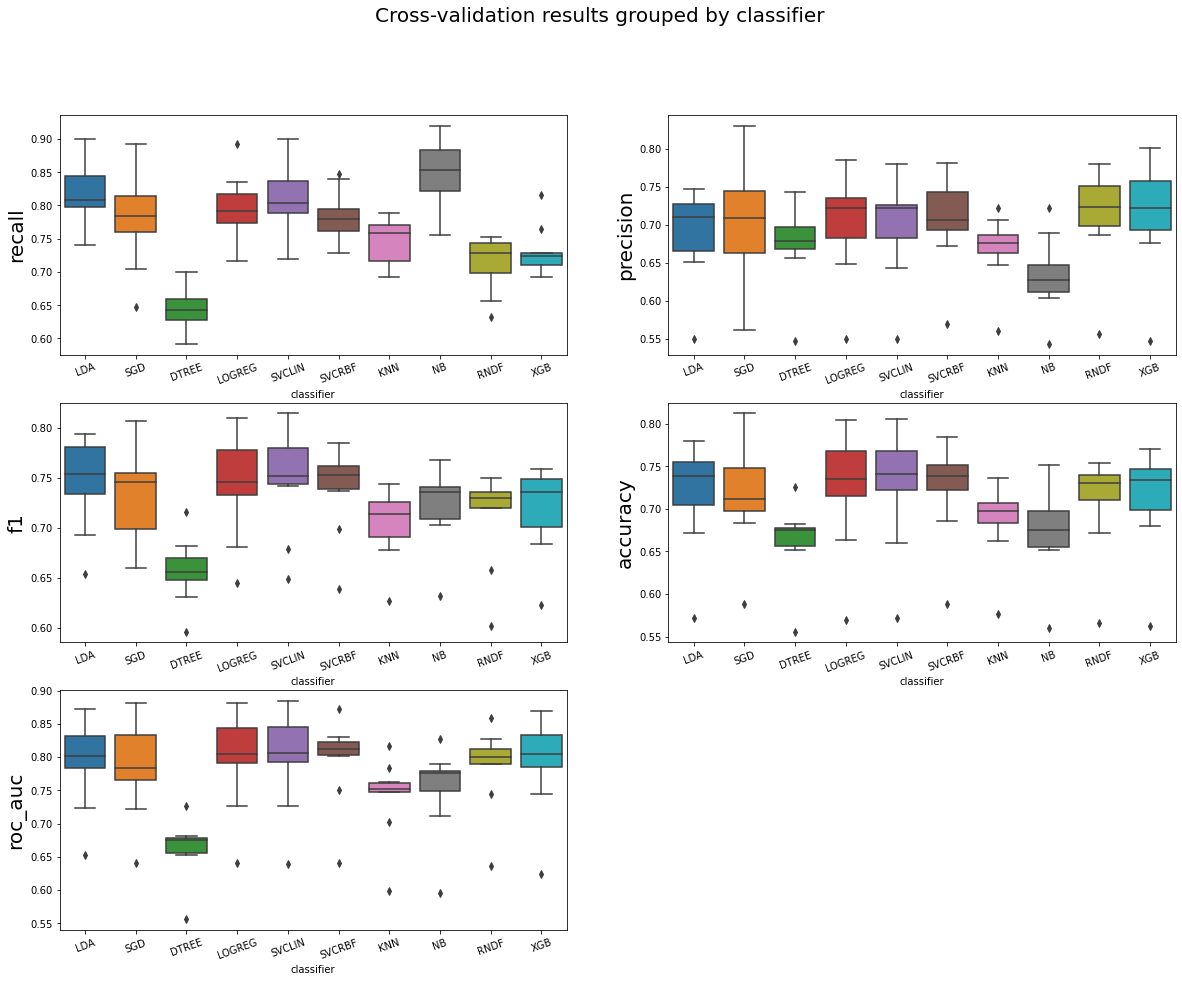

<Figure size 432x288 with 0 Axes>

In [34]:
#%% boxplot of results 

fig       = plt.figure(figsize = (20,15))
fig.tight_layout()

for i, metric in enumerate(df_xval_all.drop(['classifier'], axis = 1)):
    ax    = fig.add_subplot(3, 2, i+1)
    h     = sns.boxplot(y      = metric, 
                        x      = 'classifier', 
                        data   = df_xval_all,  
                        orient = 'v', 
                        ax     = ax)
    h.set_ylabel(metric,fontsize = 20)
    h.set_xticklabels(h.get_xticklabels(), rotation = 20)
    h.set_xlabel('classifier',fontsize = 10)
    plt.tick_params(labelsize = 10)

fig.suptitle('Cross-validation results grouped by classifier', fontsize = 20)

# save fig
fig_name  = 'x_train_xval_results.jpg'
fig_file  = os.path.join(results_dir, fig_name)

# manager   = plt.get_current_fig_manager()
# manager.window.showMaximized()

plt.show()
plt.pause(0.1) # needed for the image to be saved at full size
plt.savefig(Path(fig_file))

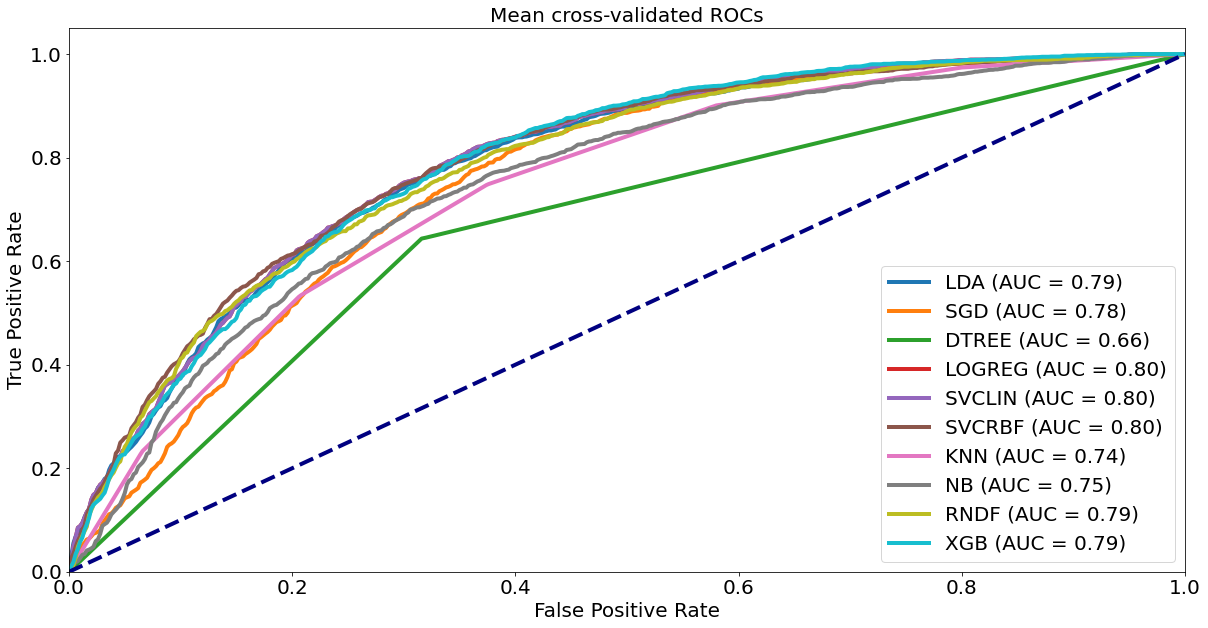

<Figure size 432x288 with 0 Axes>

In [37]:
#%% plot cross-validated ROC 

# Plot roc
plt.figure(figsize = [20,10])

for i in range(len(df_xval_roc.index)):
    
    # id classifier
    clf = df_xval_roc.loc[i, 'classifier']
    
    plt.plot(df_xval_roc.loc[i, 'fpr'], df_xval_roc.loc[i, 'tpr'], lw = 4, 
             label = df_xval_roc.loc[i, 'classifier'] + ' (AUC = %0.2f)' % df_xval_all[df_xval_all['classifier'] == clf]['roc_auc'].mean())

plt.plot([0, 1], [0, 1], color='navy', lw = 4, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Mean cross-validated ROCs', fontsize = 20)
plt.legend(loc="lower right", prop={'size': 20})
plt.tick_params(labelsize = 20)
plt.show()

# save fig
fig_name  = 'x_train_xval_roc.jpg'
fig_file  = os.path.join(results_dir, fig_name)

# manager   = plt.get_current_fig_manager()
# manager.window.showMaximized()
plt.show()
plt.pause(0.1) # needed for the image to be saved at full size
plt.savefig(Path(fig_file))


### Hyperparameter tuning

<a id='hparam'></a>
[Return to top](#top)

In [12]:
# common params 

# define scalers to try
scalers     = [StandardScaler(), 
               RobustScaler(), 
               MinMaxScaler()]

# define cross-val method
cv          = StratifiedKFold(n_splits     = 10, 
                              shuffle      = True, 
                              random_state = 42)

# define scoring metric
metric      = 'f1'

**Logistic regression classifier**

In [39]:
#%% log_reg clf

# base clf
logreg_clf    = LogisticRegression(n_jobs       = -1, 
                                   class_weight = 'balanced', 
                                   random_state = 42)

# create model pipeline 
pipe_logreg   = Pipeline([('scaler',     StandardScaler()),
                          ('classifier', logreg_clf)])

# define param grid
params_logreg = {'scaler'                   : scalers,
                 'classifier'               : [logreg_clf],
                 'classifier__penalty'      : ['l2'],
                 'classifier__C'            : np.logspace(-3, 3, 12),
                 'classifier__max_iter'     : [20000], 
                 'classifier__class_weight' : ['balanced']}

grid_logreg   = GridSearchCV(pipe_logreg, 
                             cv                 = cv, 
                             param_grid         = params_logreg, 
                             scoring            = metric,
                             refit              = True, 
                             return_train_score = False, 
                             n_jobs             = -1, 
                             verbose            = 1)

# perform tuning and extract best model
best_logreg = grid_logreg.fit(x_train, y_train).best_estimator_

print('tuning log_reg clf complete')
print('Best parameters: %s' % grid_logreg.best_params_)
print('Mean cross-validated F1: %.2f' % grid_logreg.best_score_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s


tuning log_reg clf complete
Best parameters: {'classifier': LogisticRegression(C=0.5336699231206307, class_weight='balanced',
                   max_iter=20000, n_jobs=-1, random_state=42), 'classifier__C': 0.5336699231206307, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 20000, 'classifier__penalty': 'l2', 'scaler': RobustScaler()}
Mean cross-validated F1: 0.75


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    6.6s finished


Examine the learning curve\
Note: 
the following code is adapted from sklearn example: \
https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

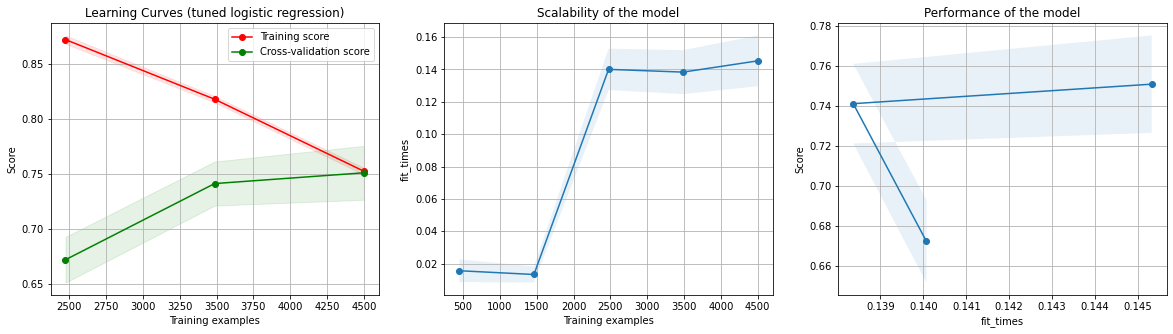

In [4]:
title     = "Learning Curves (tuned logistic regression)"

estimator = best_logreg
utils.plot_learning_curve(estimator, 
                          title, 
                          x_train, 
                          y_train, 
                          cv      = cv, 
                          n_jobs  = -1, 
                          scoring = metric)

plt.show()

**Linear SVC**

In [41]:
#%% svc_lin

# base clf
svc_lin_clf    = LinearSVC(max_iter     = 20000, 
                           class_weight = 'balanced', 
                           random_state = 42)

# create model pipeline 
pipe_svc_lin   = Pipeline([('scaler',     StandardScaler()),
                           ('classifier', svc_lin_clf)])

# define param grid
params_svc_lin = {'scaler'                   : scalers,
                  'classifier'               : [svc_lin_clf],
                  'classifier__penalty'      : ['l1', 'l2'],
                  'classifier__loss'         : ['hinge', 'squared_hinge'],
                  'classifier__C'            : np.logspace(-3, 3, 12),
                  'classifier__max_iter'     : [20000], 
                  'classifier__class_weight' : ['balanced']}

grid_svc_lin   = GridSearchCV(pipe_svc_lin, 
                              cv                 = cv, 
                              param_grid         = params_svc_lin, 
                              scoring            = metric,
                              refit              = True, 
                              return_train_score = False, 
                              n_jobs             = -1, 
                              verbose            = 1)

# perform tuning and extract best model
best_svc_lin   = grid_svc_lin.fit(x_train, y_train).best_estimator_

print('tuning svc_lin clf complete')
print('Best parameters: %s' % grid_svc_lin.best_params_)
print('Mean cross-validated F1: %.2f' % grid_svc_lin.best_score_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:  5.2min


tuning svc_lin clf complete
Best parameters: {'classifier': LinearSVC(C=0.5336699231206307, class_weight='balanced', loss='hinge',
          max_iter=20000, random_state=42), 'classifier__C': 0.5336699231206307, 'classifier__class_weight': 'balanced', 'classifier__loss': 'hinge', 'classifier__max_iter': 20000, 'classifier__penalty': 'l2', 'scaler': RobustScaler()}
Mean cross-validated F1: 0.76


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  9.3min finished


In [42]:
# pickle the model 
file_model   = os.path.join(results_dir, 'best_svc_lin.sav')
dump(best_svc_lin, open(file_model, 'wb'))

Examine the learning curve\
Note: 
the following code is adapted from sklearn example: \
https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

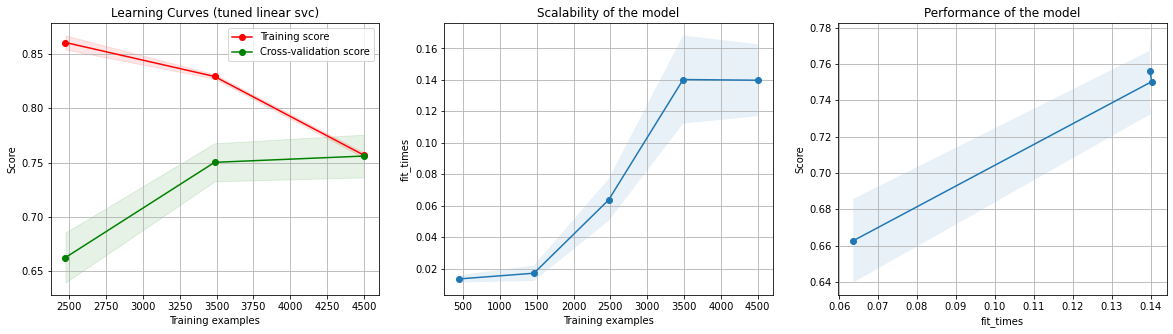

In [5]:
title     = "Learning Curves (tuned linear svc)"

estimator = best_svc_lin
utils.plot_learning_curve(estimator, 
                          title, 
                          x_train, 
                          y_train, 
                          cv      = cv, 
                          n_jobs  = -1, 
                          scoring = metric)

plt.show()

**SGD**

In [43]:
#%% sgd clf

# base clf
sgd_clf      = SGDClassifier(max_iter       = 20000,
                             tol            = 1e-4, 
                             class_weight   = 'balanced', 
                             early_stopping = True)

# create model pipeline 
pipe_sgd     = Pipeline([('scaler',     StandardScaler()),
                         ('classifier', sgd_clf)])

# define param grid
params_sgd   = {'scaler'                   : scalers,
                'classifier'               : [sgd_clf],
                'classifier__penalty'      : ['l1', 'l2', 'elasticnet'],
                'classifier__loss'         : ['hinge', 'squared_hinge', 'log', 'perceptron']}

grid_sgd     = GridSearchCV(pipe_sgd, 
                            cv                 = cv, 
                            param_grid         = params_sgd, 
                            scoring            = metric,
                            refit              = True, 
                            return_train_score = False, 
                            n_jobs             = -1, 
                            verbose            = 1)

# perform tuning and extract best model
best_sgd     = grid_sgd.fit(x_train, y_train).best_estimator_

print('tuning sgd clf complete')
print('Best parameters: %s' % grid_sgd.best_params_)
print('Mean cross-validated F1: %.2f' % grid_sgd.best_score_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.1s


tuning sgd clf complete
Best parameters: {'classifier': SGDClassifier(class_weight='balanced', early_stopping=True, max_iter=20000,
              tol=0.0001), 'classifier__loss': 'hinge', 'classifier__penalty': 'l2', 'scaler': MinMaxScaler()}
Mean cross-validated F1: 0.74


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    8.4s finished


In [44]:
# pickle the model 
file_model   = os.path.join(results_dir, 'best_sgd.sav')
dump(best_sgd, open(file_model, 'wb'))

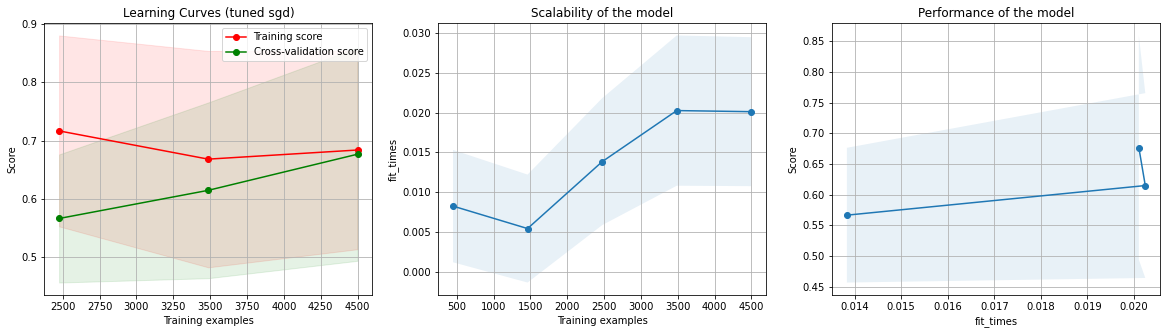

In [15]:
title     = "Learning Curves (tuned sgd)"

estimator = best_sgd
utils.plot_learning_curve(estimator, 
                          title, 
                          x_train, 
                          y_train, 
                          cv      = cv, 
                          n_jobs  = -1, 
                          scoring = metric)

plt.show()

**LDA**

In [13]:
#%% lda

# base clf
lda_clf      = LinearDiscriminantAnalysis()

# create model pipeline 
pipe_lda     = Pipeline([('scaler',     StandardScaler()),
                         ('classifier', lda_clf)])

# define param grid
params_lda   = {'scaler'                   : scalers,
                'classifier'               : [lda_clf],
                'classifier__solver'       : ['svd', 'lsqr', 'eigen'],
                'classifier__shrinkage'    : np.arange(0, 1, 0.01)}

grid_lda     = GridSearchCV(pipe_lda, 
                            cv                 = cv, 
                            param_grid         = params_lda, 
                            scoring            = metric,
                            refit              = True, 
                            return_train_score = False, 
                            n_jobs             = -1, 
                            verbose            = 1)

# perform tuning and extract best model
best_lda     = grid_lda.fit(x_train, y_train).best_estimator_

print('tuning lda clf complete')
print('Best parameters: %s' % grid_lda.best_params_)
print('Mean cross-validated F1: %.2f' % grid_lda.best_score_)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 748 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1448 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2348 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 3448 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 4748 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7948 tasks      | elapsed:  1.3min


tuning lda clf complete
Best parameters: {'classifier': LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'), 'classifier__shrinkage': 0.0, 'classifier__solver': 'lsqr', 'scaler': StandardScaler()}
Mean cross-validated F1: 0.75


[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:  1.5min finished


In [46]:
# pickle the model 
file_model   = os.path.join(results_dir, 'best_lda.sav')
dump(best_lda, open(file_model, 'wb'))

In [ ]:
title     = "Learning Curves (tuned lda)"

estimator = best_lda
utils.plot_learning_curve(estimator, 
                          title, 
                          x_train, 
                          y_train, 
                          cv      = cv, 
                          n_jobs  = -1, 
                          scoring = metric)

plt.show()

In [47]:
# save session 
import dill 
dill.dump_session('nb_hparam_tuning_complete.db')
print('session saved!')

session saved!


In [1]:
# load session 
import dill 
dill.load_session('nb_hparam_tuning_complete.db')
print('session loaded!')

session loaded!


### Ensemble methods

<a id='ensemble'></a>
[Return to top](#top)

#### XGBOOST

<a id='xgboost'></a>
[Return to top](#top)

validation set F1: 0.75


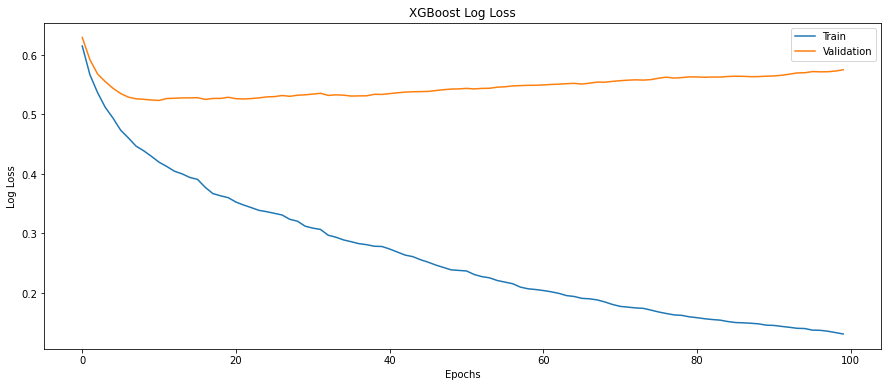

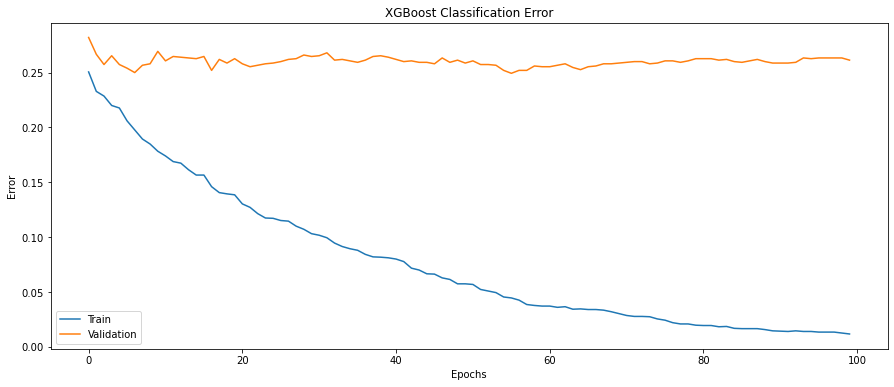

In [18]:
model = XGBClassifier()

# split data into train and validation sets
x_sub_train, x_val, y_sub_train, y_val = train_test_split(StandardScaler().fit_transform(x_train), 
                                                          y_train, 
                                                          test_size    = 0.3, 
                                                          random_state = 42)

# fit model on training data
eval_set = [(x_sub_train, y_sub_train), (x_val, y_val)]

model.fit(x_sub_train, 
          y_sub_train, 
          eval_metric = ['error', 'logloss'], 
          eval_set    = eval_set, 
          verbose     = False)

# evaluate predictions on validation set
score = f1_score(y_val, model.predict(x_val))
print('validation set F1: %.2f' % score)

# retrieve performance metrics
results = model.evals_result()
epochs  = len(results['validation_0']['error'])
x_axis  = range(0, epochs)

# plot logloss
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(x_axis, results['validation_0']['logloss'], label = 'Train')
ax.plot(x_axis, results['validation_1']['logloss'], label = 'Validation')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot error
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(x_axis, results['validation_0']['error'], label = 'Train')
ax.plot(x_axis, results['validation_1']['error'], label = 'Validation')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('XGBoost Classification Error')
plt.show()

ax.autoscale()

Learning curves clearly show overfitting w/ too many training epochs. **Early stopping** is needed.

In [19]:
# apply early stopping 
eval_set = [(x_val, y_val)]

model.fit(x_sub_train, 
          y_sub_train, 
          early_stopping_rounds = 10,
          eval_metric = ['logloss'], 
          eval_set    = eval_set, 
          verbose     = False)

# evaluate predictions on validation set
score = f1_score(y_val, model.predict(x_val))
print('validation set F1: %.2f' % score)

validation set F1: 0.75


#### Voting classifier

<a id='vote_clf'></a>
[Return to top](#top)

In [48]:
v_models = list()

# append models 
v_models.append(('best_logreg',  best_logreg))
v_models.append(('best_svc_lin', best_svc_lin))
v_models.append(('best_lda',     best_lda))
            
# define the soft voting ensemble
vclf     = VotingClassifier(estimators = v_models, voting = 'hard')

In [49]:
# eval performance via cv
scores = cross_val_score(vclf, 
                         x_train, 
                         y_train, 
                         cv      = cv, 
                         scoring = metric, 
                         verbose = 1, 
                         n_jobs  = -1)

print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


F1: 0.75 (+/- 0.02)


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


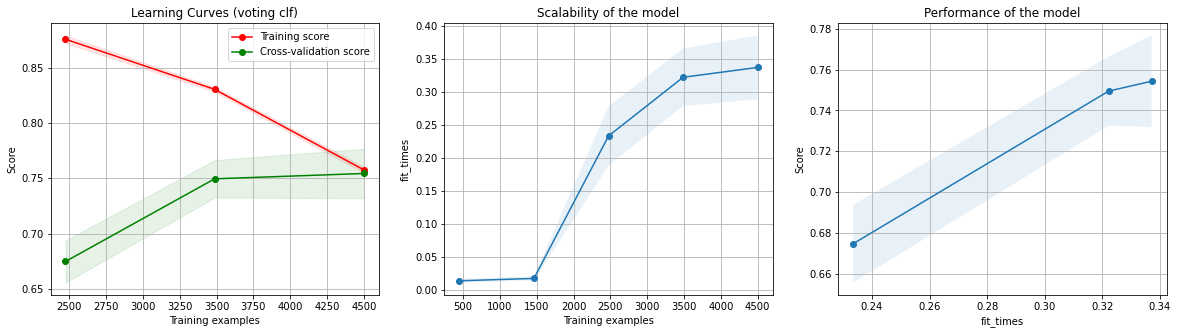

In [50]:
title     = "Learning Curves (voting clf)"

estimator = vclf
utils.plot_learning_curve(estimator, 
                          title, 
                          x_train, 
                          y_train, 
                          cv      = cv, 
                          n_jobs  = -1, 
                          scoring = metric)

plt.show()

#### Stacking classifier

<a id='stacking_clf'></a>
[Return to top](#top)

**Method 1: simple stacked classifier**

Using default linear models 

In [30]:
sclf_1 = StackingClassifier(classifiers     = [lda, 
                                               logreg, 
                                               svc_lin],                                              
                            meta_classifier = LogisticRegression())

In [31]:
# eval performance via cv
scores = cross_val_score(sclf_1, 
                         x_train, 
                         y_train, 
                         cv      = cv, 
                         scoring = metric, 
                         verbose = 1, 
                         n_jobs  = -1)

print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.0s remaining:    6.6s


F1: 0.75 (+/- 0.02)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.4s finished


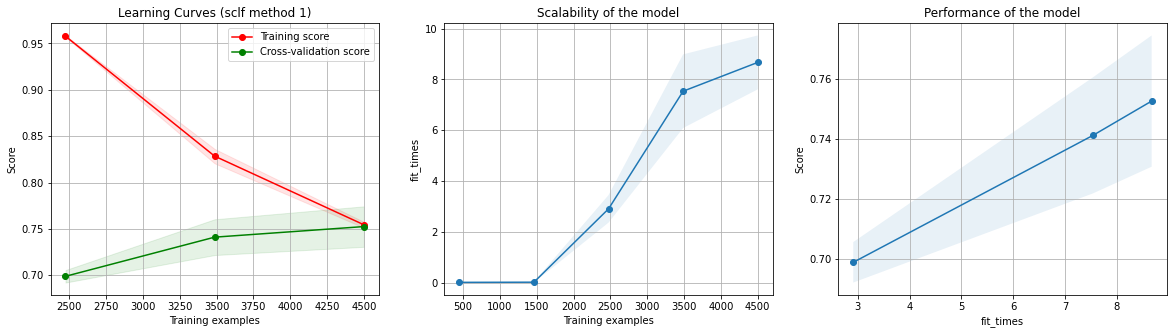

In [17]:
title     = "Learning Curves (sclf method 1)"

estimator = sclf_1
utils.plot_learning_curve(estimator, 
                          title, 
                          x_train, 
                          y_train, 
                          cv      = cv, 
                          n_jobs  = -1, 
                          scoring = metric)

plt.show()

**Method 2: using probabilities as meta-features**

svc_lin omitted b/c does not have **'predict_proba'** attribute

In [28]:
sclf_2 = StackingClassifier(classifiers     = [lda, logreg],
                            use_probas      = True,
                            average_probas  = False,
                            meta_classifier = LogisticRegression())

In [29]:
# eval performance via cv
scores = cross_val_score(sclf_2, 
                         x_train, 
                         y_train, 
                         cv      = cv, 
                         scoring = metric, 
                         verbose = 1, 
                         n_jobs  = -1)

print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


F1: 0.75 (+/- 0.02)


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


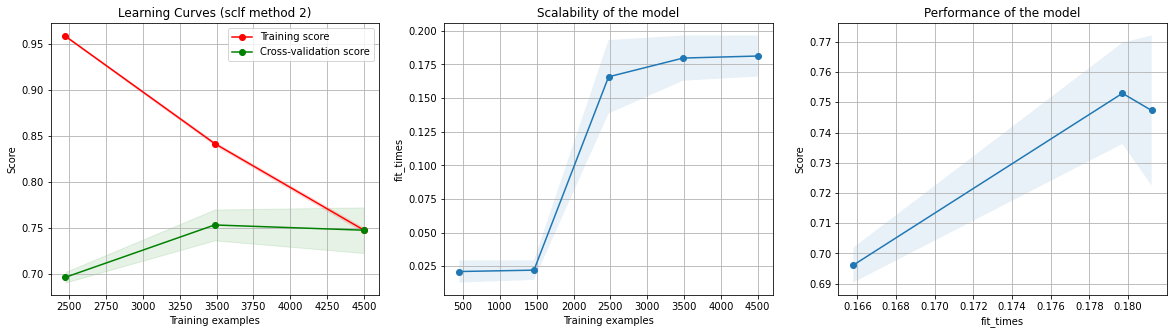

In [18]:
title     = "Learning Curves (sclf method 2)"

estimator = sclf_2
utils.plot_learning_curve(estimator, 
                          title, 
                          x_train, 
                          y_train, 
                          cv      = cv, 
                          n_jobs  = -1, 
                          scoring = metric)

plt.show()

**Method 3: stacked classification and grid search**

In [98]:
# define the base models

# lda
lda_clf      = LinearDiscriminantAnalysis()

# svc_lin
svc_lin_clf  = LinearSVC(max_iter     = 20000, 
                         class_weight = 'balanced', 
                         random_state = 42)

# logreg 
# base clf
logreg_clf   = LogisticRegression(n_jobs       = -1, 
                                  class_weight = 'balanced', 
                                  random_state = 42, 
                                  max_iter     = 20000)

# append base models
level0       = [lda_clf, svc_lin_clf, logreg_clf]

# define meta learner model
level1       = LogisticRegression()

In [99]:
# define param grid
# params_stack = {'lineardiscriminantanalysis__solver'    : ['svd', 'lsqr', 'eigen'],
#                 'lineardiscriminantanalysis__shrinkage' : np.arange(0, 1, 0.1), 
#                 'linearsvc__penalty'                    : ['l1', 'l2'],
#                 'linearsvc__loss'                       : ['hinge', 'squared_hinge'],
#                 'linearsvc__C'                          : [0.001, 0.1, 1, 10, 100, 1000],
#                 'logisticregression__penalty'           : ['l2'],
#                 'logisticregression__C'                 : [0.001, 0.1, 1, 10, 100, 1000],
#                 'meta_classifier__C'                    : [0.001, 0.1, 1, 10, 100, 1000]}

params_stack = {'meta_classifier__C'         : np.logspace(-3, 3, 12)}

In [101]:
sclf_3     = StackingClassifier(classifiers     = level0, 
                                meta_classifier = level1)

grid_stack = GridSearchCV(estimator          = sclf_3, 
                          param_grid         = params_stack, 
                          scoring            = metric,
                          refit              = True,
                          cv                 = cv,
                          return_train_score = False,
                          n_jobs             = -1,
                          verbose            = 1)


# perform tuning and extract best model
best_sclf_3 = grid_stack.fit(StandardScaler().fit_transform(x_train), y_train).best_estimator_

print('tuning stacking clf complete')
print('Best parameters: %s' % grid_stack.best_params_)
print('Mean cross-validated F1: %.2f' % grid_stack.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.3min finished


tuning stacking clf complete
Best parameters: {'meta_classifier__C': 0.001}
Mean cross-validated F1: 0.75


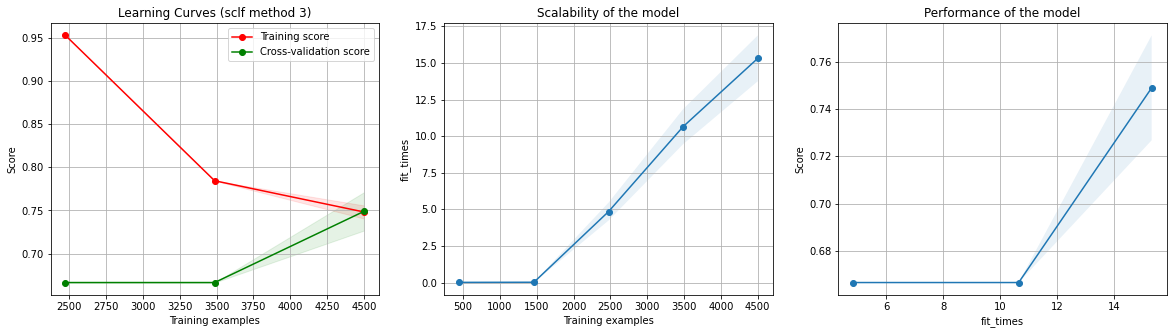

In [19]:
title     = "Learning Curves (sclf method 3)"

estimator = best_sclf_3
utils.plot_learning_curve(estimator, 
                          title, 
                          x_train, 
                          y_train, 
                          cv      = cv, 
                          n_jobs  = -1, 
                          scoring = metric)

plt.show()

**Method 4: using pre-fitted classifiers**\
Use hyperparam-tuned linear classifiers

In [106]:
sclf_5 = StackingClassifier(classifiers         = [best_lda, best_logreg, best_svc_lin],
                            meta_classifier     = LogisticRegression(C = best_sclf_3.meta_classifier.C), 
                            fit_base_estimators = False)

Please note that fit_base_estimators=False is **incompatible to any form of cross-validation** that is done in e.g., model_selection.cross_val_score or model_selection.GridSearchCV, etc., since it would require the classifiers to be refit to the training folds. Thus, only use fit_base_estimators=False if you want to make a prediction directly without cross-validation.

In [107]:
# manually code up 10 fold cv

scores = list()

# cv is the stratifiedkfold obj defined earlier
for train_inds, test_inds in cv.split(x_train, y_train):
    
    # split the train/val folds
    x_fold_train, x_fold_test = x_train.loc[train_inds], x_train.loc[test_inds]
    y_fold_train, y_fold_test = np.array(y_train)[train_inds], np.array(y_train)[test_inds]
    
    # train 
    sclf_5.fit(x_fold_train, y_fold_train)
    
    # predict and get F1 score
    score = f1_score(y_fold_test, sclf_5.predict(x_fold_test))
    
    scores.append(score)
    
print('cv done!')

cv done!


In [108]:
print('Mean cross-validated F1: %.2f' % np.array(scores).mean())
print('std cross-validated F1: %.2f' % np.array(scores).std())

Mean cross-validated F1: 0.76
std cross-validated F1: 0.02


### Retrain final models

<a id='retrain'></a>
[Return to top](#top)

Retrain best model on the entire training set 

In [42]:
# default models

svc_rbf_final = svc_rbf.fit(x_train, y_train)
score         = f1_score(y_train, svc_rbf_final.predict(x_train))
print('svc_rbf_final F1: %.2f' % score)

rndf_final    = rndf.fit(x_train, y_train)
score         = f1_score(y_train, rndf_final.predict(x_train))
print('rndf_final F1: %.2f' % score)

xgb_final     = XGBClassifier().fit(x_sub_train, 
                                    y_sub_train, 
                                    early_stopping_rounds = 10,
                                    eval_metric = ['logloss'], 
                                    eval_set    = eval_set, 
                                    verbose     = False)

score         = f1_score(y_train, xgb_final.predict(StandardScaler().fit_transform(x_train)))
print('xgb_final F1: %.2f' % score)

# add pipeline to final xgboost clf
xgb_final     = make_pipeline(StandardScaler().fit(x_train), xgb_final)

adb_final     = adb.fit(x_train, y_train)
score         = f1_score(y_train, adb_final.predict(x_train))
print('adb_final F1: %.2f' % score)

gb_final      = gb.fit(x_train, y_train)
score         = f1_score(y_train, gb_final.predict(x_train))
print('gb_final F1: %.2f' % score)

print('all done!')

svc_rbf_final F1: 0.79
rndf_final F1: 0.73
xgb_final F1: 0.81
adb_final F1: 0.75
gb_final F1: 0.79
all done!


In [113]:
# hyperparam tuned models 

svc_lin_final   = best_svc_lin.fit(x_train, y_train) # good 
score           = f1_score(y_train, svc_lin_final.predict(x_train))
print('svc_lin_final F1: %.2f' % score)

logreg_final    = best_logreg.fit(x_train, y_train)  # good
score           = f1_score(y_train, logreg_final.predict(x_train))
print('logreg_final F1: %.2f' % score)

lda_final       = best_lda.fit(x_train, y_train)
score           = f1_score(y_train, lda_final.predict(x_train))
print('lda_final F1: %.2f' % score)

sgd_final       = best_sgd.fit(x_train, y_train)
score           = f1_score(y_train, sgd_final.predict(x_train))
print('sgd_final F1: %.2f' % score)

print('all done!')

svc_lin_final F1: 0.76
logreg_final F1: 0.75
lda_final F1: 0.75
sgd_final F1: 0.73
all done!


In [114]:
# stacking ensemble 
sclf_1_final = sclf_1.fit(x_train, y_train)
score        = f1_score(y_train, sclf_1_final.predict(x_train))
print('sclf_1_final F1: %.2f' % score)

sclf_2_final = sclf_2.fit(x_train, y_train)
score        = f1_score(y_train, sclf_2_final.predict(x_train))
print('sclf_2_final F1: %.2f' % score)

sclf_3_final = best_sclf_3.fit(x_train, y_train)
score        = f1_score(y_train, sclf_3_final.predict(x_train))
print('sclf_3_final F1: %.2f' % score)

sclf_5_final = sclf_5.fit(x_train, y_train)
score        = f1_score(y_train, sclf_5_final.predict(x_train))
print('sclf_5_final F1: %.2f' % score)

print('all done!')

sclf_1_final F1: 0.76
sclf_2_final F1: 0.75
sclf_3_final F1: 0.76
sclf_5_final F1: 0.76
all done!


### Prediction on test set

<a id='pred'></a>
[Return to top](#top)

Load test data 

In [36]:
# process test data 
df_test  = pd.read_csv(file_test)

# feats
x_test   = df_test.iloc[:, 1:]

# remove low var feats (as in x_train)
x_test   = x_test[x_test.columns[selector_var.get_support(indices = True)]]

# tweet id
t_id     = df_test.id.to_frame()

In [43]:
# gather models 

final_models = {'lda'      : lda_final,
                'sgd'      : sgd_final,
                'svc_lin'  : svc_lin_final,
                'logreg'   : logreg_final, 
                'svc_rbf'  : svc_rbf_final,
                'rndf'     : rndf_final,
                'xgb'      : xgb_final, 
                'adb'      : adb_final, 
                'gb'       : gb_final, 
                'sclf_1'   : sclf_1_final, 
                'sclf_2'   : sclf_2_final,   
                'sclf_5'   : sclf_5_final}

In [44]:
#%% make prediction 

for name, model in final_models.items(): 
    
    # make prediction 
    pred     = model.predict(x_test)
    
    # convert to text labels
    pred     = ['SARCASM' if i == 1 else 'NOT_SARCASM' for i in pred]
    
    pred     = pd.DataFrame(pred, columns = ['predictions'])

    # concat into df
    answer   = pd.concat([t_id, pred], axis = 1)
    
    # construct file name 
    file_ans = Path(os.path.join(os.getcwd(), 'answer_' + name + '.txt'))
    
    # name the file, based on the classifier
    answer.to_csv(file_ans, header = None, index = None, sep = ',')
    
print('all predictions completed!')

all predictions completed!


In [51]:
# save session 
import dill 
dill.dump_session('nb_stacking_complete.db')
print('session saved!')

session saved!


In [2]:
# load session 
import dill 
dill.load_session('nb_stacking_complete.db')
print('session loaded!')

session loaded!
